In [28]:
# Colab cell 0 — install & imports
!pip install -q tensorflow opencv-python-headless==4.7.0.72

import numpy as np, pandas as pd, matplotlib.pyplot as plt, json, pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 21.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.7.0.72 which is incompatible.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.7.0.72 which is incompatible.


In [29]:
# Colab cell 1 — load CSVs and remap labels safely
train_df = pd.read_csv('/content/asl_dataset/sign_mnist_train.csv')
test_df  = pd.read_csv('/content/asl_dataset/sign_mnist_test.csv')

def fix_labels_array(labels):
    labels = np.array(labels).astype(int).copy()
    # subtract 1 for values > 9 (removes gap at 9), subtract 1 again for >25 if present
    labels[labels > 9] -= 1   # shifts labels >=10 down by 1 (removes label 9)
    labels[labels > 24] -= 1  # defensive: if 25 present, shift down as well
    return labels

X = train_df.drop('label', axis=1).values.astype('float32')
y = fix_labels_array(train_df['label'].values)

X_test = test_df.drop('label', axis=1).values.astype('float32')
y_test_raw = fix_labels_array(test_df['label'].values)

print('Unique train labels after fix:', np.unique(y))
print('Unique test labels after fix: ', np.unique(y_test_raw))


Unique train labels after fix: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Unique test labels after fix:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [30]:
# Colab cell 2 — reshape and one-hot
X = X / 255.0
X = X.reshape(-1, 28, 28, 1).astype('float32')
y = to_categorical(y, num_classes=24)

X_test = X_test / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32')
y_test = to_categorical(y_test_raw, num_classes=24)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=np.argmax(y,axis=1), random_state=42)
print('Shapes:', X_train.shape, X_val.shape, X_test.shape)


Shapes: (23336, 28, 28, 1) (4119, 28, 28, 1) (7172, 28, 28, 1)


In [31]:
# Colab cell 3 — model architecture (paste and run)
def build_model():
    m = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1), padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(24, activation='softmax')
    ])
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m

model = build_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,904 (1.51 MB)

 Trainable params: 394,456 (1.50 MB)

 Non-trainable params: 448 (1.75 KB)

In [32]:
# Colab cell 4 — augmentation + callbacks
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.12,
    height_shift_range=0.12,
    zoom_range=0.12,
    shear_range=0.05
)
datagen.fit(X_train)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('asl_best.h5', monitor='val_loss', save_best_only=True)
]


In [33]:
# Colab cell 4 — augmentation + callbacks
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.12,
    height_shift_range=0.12,
    zoom_range=0.12,
    shear_range=0.05
)
datagen.fit(X_train)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('asl_best.h5', monitor='val_loss', save_best_only=True)
]


In [34]:


# Colab cell 5 — training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=128),
    steps_per_epoch = max(1, len(X_train)//128),
    validation_data=(X_val, y_val),
    epochs=40,
    callbacks=callbacks,
    verbose=2
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


182/182 - 19s - 103ms/step - accuracy: 0.5029 - loss: 1.6012 - val_accuracy: 0.1076 - val_loss: 3.4033 - learning_rate: 1.0000e-03
Epoch 2/40


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


182/182 - 0s - 2ms/step - accuracy: 0.7188 - loss: 0.7623 - val_accuracy: 0.1059 - val_loss: 3.3863 - learning_rate: 1.0000e-03
Epoch 3/40


182/182 - 8s - 44ms/step - accuracy: 0.8398 - loss: 0.4729 - val_accuracy: 0.3705 - val_loss: 2.1401 - learning_rate: 1.0000e-03
Epoch 4/40


182/182 - 0s - 2ms/step - accuracy: 0.8984 - loss: 0.3035 - val_accuracy: 0.3848 - val_loss: 2.0888 - learning_rate: 1.0000e-03
Epoch 5/40


182/182 - 7s - 40ms/step - accuracy: 0.9247 - loss: 0.2227 - val_accuracy: 0.8674 - val_loss: 0.3366 - learning_rate: 1.0000e-03
Epoch 6/40


182/182 - 1s - 4ms/step - accuracy: 0.9453 - loss: 0.1704 - val_accuracy: 0.8701 - val_loss: 0.3340 - learning_rate: 1.0000e-03
Epoch 7/40


182/182 - 8s - 45ms/step - accuracy: 0.9530 - loss: 0.1422 - val_accuracy: 0.9558 - val_loss: 0.1252 - learning_rate: 1.0000e-03
Epoch 8/40


182/182 - 0s - 2ms/step - accuracy: 0.9219 - loss: 0.1514 - val_accuracy: 0.9602 - val_loss: 0.1124 - learning_rate: 1.0000e-03
Epoch 9/40
182/182 - 8s - 46ms/step - accuracy: 0.9670 - loss: 0.1029 - val_accuracy: 0.8492 - val_loss: 0.4988 - learning_rate: 1.0000e-03
Epoch 10/40
182/182 - 0s - 2ms/step - accuracy: 0.9844 - loss: 0.0439 - val_accuracy: 0.8793 - val_loss: 0.3960 - learning_rate: 1.0000e-03
Epoch 11/40


182/182 - 7s - 40ms/step - accuracy: 0.9745 - loss: 0.0754 - val_accuracy: 0.9983 - val_loss: 0.0064 - learning_rate: 1.0000e-03
Epoch 12/40
182/182 - 0s - 2ms/step - accuracy: 0.9297 - loss: 0.2029 - val_accuracy: 0.9990 - val_loss: 0.0070 - learning_rate: 1.0000e-03
Epoch 13/40
182/182 - 8s - 44ms/step - accuracy: 0.9796 - loss: 0.0607 - val_accuracy: 0.9891 - val_loss: 0.0364 - learning_rate: 1.0000e-03
Epoch 14/40

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
182/182 - 0s - 2ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9888 - val_loss: 0.0353 - learning_rate: 1.0000e-03
Epoch 15/40


182/182 - 8s - 44ms/step - accuracy: 0.9883 - loss: 0.0361 - val_accuracy: 0.9995 - val_loss: 0.0028 - learning_rate: 5.0000e-04
Epoch 16/40


182/182 - 0s - 2ms/step - accuracy: 0.9922 - loss: 0.0333 - val_accuracy: 0.9998 - val_loss: 0.0024 - learning_rate: 5.0000e-04
Epoch 17/40
182/182 - 7s - 40ms/step - accuracy: 0.9916 - loss: 0.0255 - val_accuracy: 0.9995 - val_loss: 0.0032 - learning_rate: 5.0000e-04
Epoch 18/40
182/182 - 0s - 2ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.9995 - val_loss: 0.0027 - learning_rate: 5.0000e-04
Epoch 19/40

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
182/182 - 10s - 55ms/step - accuracy: 0.9924 - loss: 0.0237 - val_accuracy: 0.9968 - val_loss: 0.0084 - learning_rate: 5.0000e-04
Epoch 20/40
182/182 - 0s - 2ms/step - accuracy: 0.9844 - loss: 0.0253 - val_accuracy: 0.9976 - val_loss: 0.0075 - learning_rate: 2.5000e-04
Epoch 21/40


182/182 - 8s - 45ms/step - accuracy: 0.9948 - loss: 0.0167 - val_accuracy: 1.0000 - val_loss: 1.2151e-04 - learning_rate: 2.5000e-04
Epoch 22/40
182/182 - 0s - 2ms/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 1.3756e-04 - learning_rate: 2.5000e-04
Epoch 23/40
182/182 - 7s - 39ms/step - accuracy: 0.9951 - loss: 0.0148 - val_accuracy: 1.0000 - val_loss: 1.8385e-04 - learning_rate: 2.5000e-04
Epoch 24/40

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
182/182 - 0s - 2ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 1.9027e-04 - learning_rate: 2.5000e-04
Epoch 25/40
182/182 - 8s - 44ms/step - accuracy: 0.9957 - loss: 0.0133 - val_accuracy: 0.9998 - val_loss: 0.0010 - learning_rate: 1.2500e-04
Epoch 26/40
182/182 - 0s - 2ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.9998 - val_loss: 9.7828e-04 - learning_rate: 1.2500e-04
Epoch 27/40


182/182 - 9s - 48ms/step - accuracy: 0.9971 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 1.4856e-05 - learning_rate: 1.2500e-04
Epoch 28/40
182/182 - 0s - 2ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 1.5186e-05 - learning_rate: 1.2500e-04
Epoch 29/40
182/182 - 7s - 39ms/step - accuracy: 0.9971 - loss: 0.0110 - val_accuracy: 1.0000 - val_loss: 7.8227e-05 - learning_rate: 1.2500e-04
Epoch 30/40

Epoch 30: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
182/182 - 0s - 2ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 7.6405e-05 - learning_rate: 1.2500e-04
Epoch 31/40
182/182 - 8s - 44ms/step - accuracy: 0.9970 - loss: 0.0100 - val_accuracy: 1.0000 - val_loss: 8.5855e-05 - learning_rate: 6.2500e-05
Epoch 32/40
182/182 - 0s - 2ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 8.6423e-05 - learning_rate: 6.2500e-05
Epoch 33/40

Epoch 33: ReduceLROnPlateau reducing learning rate to 3

Test accuracy: 99.92%
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       331
           1     1.0000    1.0000    1.0000       432
           2     1.0000    1.0000    1.0000       310
           3     1.0000    1.0000    1.0000       245
           4     1.0000    0.9880    0.9939       498
           5     1.0000    1.0000    1.0000       247
           6     1.0000    1.0000    1.0000       348
           7     1.0000    1.0000    1.0000       436
           8     1.0000    1.0000    1.0000       288
           9     1.0000    1.0000    1.0000       331
          10     1.0000    1.0000    1.0000       209
          11     0.9850    1.0000    0.9924       394
          12     1.0000    1.0000    1.0000       291
          13     1.0000    1.0000    1.0000       246
          14     1.0000    1.0000    1.0000       347
          15     1.0000    1.0000    1.0000       164
          16     1

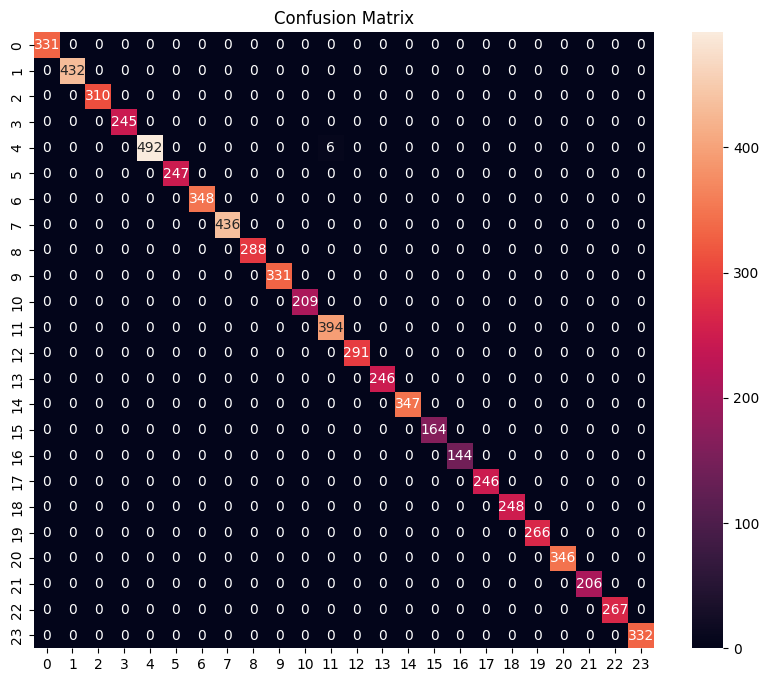

In [35]:
# Colab cell 6 — evaluation
from sklearn.metrics import classification_report, confusion_matrix
model = build_model()
model.load_weights('asl_best.h5')  # load best

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {acc*100:.2f}%")

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, digits=4))

# confusion matrix (optional visual)
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()


In [39]:
# Colab cell 8 — save final model and class map (explicit letters)
model.save('asl_final.h5')  # full model

# Sign-MNIST label mapping: 0->A,1->B,... but remember J,Z excluded
import string
letters = [c for c in string.ascii_uppercase if c not in ('J','Z')]
with open('classes_letters.json','w') as f:
    json.dump(letters, f)

# download
from google.colab import files
files.download('asl_final.h5')
files.download('classes_letters.json')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
!mkdir -p ASL-Recognition/notebooks ASL-Recognition/model
!cp /content/asl_dataset/sign_mnist_train.csv ASL-Recognition/ 2>/dev/null || true
!cp /content/asl_dataset/sign_mnist_test.csv ASL-Recognition/ 2>/dev/null || true
!cp asl_final.h5 ASL-Recognition/model/
!cp classes_letters.json ASL-Recognition/model/
!cp /content/ASL_Recognition.ipynb ASL-Recognition/notebooks/


cp: cannot stat '/content/ASL_Recognition.ipynb': No such file or directory


In [41]:
%%writefile ASL-Recognition/README.md
# ASL Recognition Project

A deep learning model trained on Sign-MNIST to recognize American Sign Language (A–Y).
Includes:
- Jupyter notebook (`ASL_Training.ipynb`)
- Trained model (`asl_final.h5`)
- Live camera demo (`asl_camera_recognition.py`)

## Run locally
```bash
pip install -r requirements.txt
python src/asl_camera_recognition.py


Writing ASL-Recognition/README.md


In [61]:
!git config --global user.name "Tjindl"
!git config --global user.email "tjinda01@student.ubc.ca"

In [62]:
%cd ASL-Recognition

[Errno 2] No such file or directory: 'ASL-Recognition'
/content/ASL-Recognition


In [63]:
!git init

Reinitialized existing Git repository in /content/ASL-Recognition/.git/


In [64]:
!git add .

In [65]:
!git commit -m "Initial commit: model, notebook, and training scripts"

On branch main
nothing to commit, working tree clean


In [66]:
!git remote add origin https://github.com/Tjindl/ASL-Recognition.git


error: remote origin already exists.


In [67]:
!git branch -M main


In [68]:

!git push -u origin main

fatal: could not read Username for 'https://github.com': No such device or address


In [69]:
!git remote set-url origin https://github.com/Tjindl/ASL-Recognition.git


In [70]:
!git add .
!git commit -m "Add ASL CNN model and notebook"
!git push origin main


On branch main
nothing to commit, working tree clean
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 30.81 MiB | 2.17 MiB/s, done.
Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File sign_mnist_train.csv is 79.42 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/Tjindl/ASL-Recognition.git
 * [new branch]      main -> main
